#### Дано:
- дан класс DB_SCAN кластеризации данных

#### Требуется:
- реализовать эвристический метод побора гиперпараметра eps:

1. Выберите значение гиперпараметра m. Обычно используются значения от 3 до 9, чем более неоднородный ожидается датасет, и чем больше уровень шума, тем большим следует взять m.

2. Вычислите среднее расстояние по m ближайшим соседям для каждой точки. Т.е. если m=3, нужно выбрать трёх ближайших соседей, сложить расстояния до них и поделить на три.

3. Отсортируйте полученные значения по возрастанию и выведите на экран.

4. Гиперпараметр eps следует взять в полосе, где происходит самый сильный перегиб графика. Чем больше eps, тем больше получатся кластеры, и тем меньше их будет.

- проверить результат подбора параметра eps - показать результат кластеризации для заданного распределение точек при eps меньшим, равным и большим рекомендованного значения
- (не обязательно) попытаться автоматизировать подбор eps согласно эвристики без участия человека  (без построения и анализа графика)

In [2]:
import pygame
import numpy as np

# Функция для генерации точек
def generate(width: int, height: int, radius=20):
    points = np.empty((0, 2), dtype='f')

    c_radius = 2
    c_color = (0, 0, 255)
    c_thickness = 0

    bg_color = (255, 255, 255)
    screen = pygame.display.set_mode((width, height))
    pygame.display.set_caption('Points Generator')

    running = True
    pushing = False

    while running:

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.MOUSEBUTTONDOWN:
                pushing = True
            elif event.type == pygame.MOUSEBUTTONUP:
                pushing = False
        if pushing:
            (x, y) = pygame.mouse.get_pos()
            # coord = [x, y]
            r = np.random.uniform(0, radius)
            t = np.random.uniform(0, 2 * np.pi)
            coord = [x + r * np.cos(t), height - (y + r * np.sin(t))]  # Отражение относительно оси Х
            if coord not in points:  # Если значение уникально, то добавляем
                points = np.append(points, [coord], axis=0)

        screen.fill(bg_color)
        for point in points:
            # При отрисовке отражаем обратно
            pygame.draw.circle(screen, c_color, (int(point[0]), height - int(point[1])), c_radius, c_thickness)
        pygame.display.flip()

    pygame.quit()
    return points

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [10]:
points = generate(500, 500, radius=40)

In [11]:
class DBScan():
    
    def __init__(self, dataset, eps=None, min_samples=10):
        self.dataset = dataset # Данные для кластеризации
        self.eps = eps
        self.min_samples = min_samples
        self.n_clusters = 0
        self.clusters = {0:[]}
        self.visited = set()
        self.clustered = set()
        self.labels = np.array([], dtype='i')
        self.fitted = True
        
    def dist(self, list1, list2):
        return np.linalg.norm(np.array(list1) - np.array(list2))
    
    def neighbours_querry(self, center):
        return [list(x) for x in self.dataset if self.dist(x, center) < self.eps]
    
    def expand_cluster(self, root):
        # root - корневая точка кластера
        self.n_clusters += 1
        self.clusters[self.n_clusters] = []
        self.clustered.add(tuple(root))
        self.clusters[self.n_clusters].append(list(root))
        neighbours = self.neighbours_querry(root)
        while neighbours:
            curr_point = neighbours.pop()
            if tuple(curr_point) not in self.visited:
                self.visited.add(tuple(curr_point))
                curr_neighbours = self.neighbours_querry(curr_point)
                if len(curr_neighbours) > self.min_samples:
                    neighbours.extend(curr_neighbours)
            if tuple(curr_point) not in self.clustered:
                self.clustered.add(tuple(curr_point))
                self.clusters[self.n_clusters].append(curr_point)
                if curr_point in self.clusters[0]:
                    self.clusters[0].remove(curr_point)
                    
    def get_labels(self):
        for point in self.dataset:
            for label, cluster in self.clusters.items(): # {0:[...],1:[...],2:[...], ... }
                if list(point) in cluster:
                    self.labels = np.append(self.labels, label)
                    
            
            
    def fit(self):
        if not self.eps:
            self.eps_estimation(m=self.min_samples, auto=True)
        for point in self.dataset:
            point = list(point)
            if tuple(point) in self.visited:
                continue
            self.visited.add(tuple(point))
            neighbours = self.neighbours_querry(point)
            if len(neighbours) < self.min_samples:
                self.clusters[0].append(point)
            else:
                self.expand_cluster(point)
        self.fitted = True
        self.get_labels()
    
    def eps_estimation(self, m=6, auto=False):
        # Вычилсляем расстояния от каждой точки до других
        dists = np.zeros((self.dataset.shape[0]-1,self.dataset.shape[0]-1))
        # Получим треугольную матрицу расстояний
        for i in range(self.dataset.shape[0] - 1):
            for j in range(i+1, self.dataset.shape[0]):
                dists[i,j-1] = self.dist(self.dataset[i], self.dataset[j])
        dists = dists + dists.T # Матрица расстояний не включая расстояний между одной и той же точкой
        dists.sort(axis=1) # Сортируем строки по возрастанию
        mean_m = np.sort(dists[:,:m].mean(axis=1)) # Для m ближайших расстояний вычисляем среднее и сортируем по возрастанию
        dy = mean_m[1:]-mean_m[:len(mean_m)-1] # Коэффициенты наклона
        min_i = np.argmin(np.abs(dy - 1)) # Индекс точки в которой коэффициент наклона ближе всего к 1
        
        if not auto: # Ручной подбор
            print("----------------- Информация -----------------")
            print(f"[DBScan] Наибольший перегиб происходит между {min_i} и {min_i+1} точками")
            print(f"[DBScan] Значение коэфицента наклона: {dy[min_i]}")
            print(f"[DBScan] Значение eps для этих точек: {mean_m[min_i]} и {mean_m[min_i+1]}")
            print(f"[DBScan] Рекомендуемое значение eps: {round((mean_m[min_i] + mean_m[min_i+1])/2)}")
            print("----------------------------------------------")
            import matplotlib.pyplot as plt
            plt.plot(mean_m[:min_i])
            plt.plot(np.append(np.full(min_i,np.nan),mean_m[min_i:]))
            plt.axvline(x=min_i, linestyle='--', c='k',lw=0.5)
            plt.axhline(y=(mean_m[min_i] + mean_m[min_i+1])/2,linestyle='--', c='k',lw=0.5)
        else: # Автоматическая установка значения eps
            self.eps = (mean_m[min_i] + mean_m[min_i+1])/2
            print(f"[DBScan] Значение eps вычисленно автоматически: eps={(mean_m[min_i] + mean_m[min_i+1])/2}")
        

Модель с рекомендуемым параметром $\varepsilon = 9.1990134630247$:

[DBScan] Значение eps вычисленно автоматически: eps=16.27636675150209
----------------- Информация -----------------
[DBScan] Наибольший перегиб происходит между 1153 и 1154 точками
[DBScan] Значение коэфицента наклона: 0.9955764487062737
[DBScan] Значение eps для этих точек: 15.778578527148952 и 16.774154975855225
[DBScan] Рекомендуемое значение eps: 16
----------------------------------------------


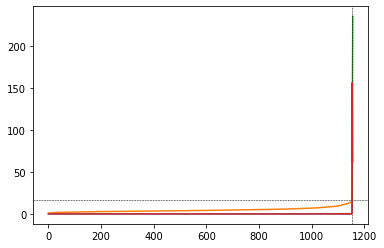

In [12]:
model = DBScan(points, min_samples=6) # Если eps не задано, модель посчиатет ее автоматически
model.fit()
model.eps_estimation(m=6) # Проверим вручную

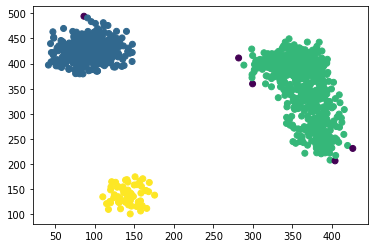

In [13]:
import matplotlib.pyplot as plt

plt.scatter(points[:,0],points[:,1],c=model.labels)

Модель с параметром $\varepsilon$ меньшим, чем рекомендуемое:

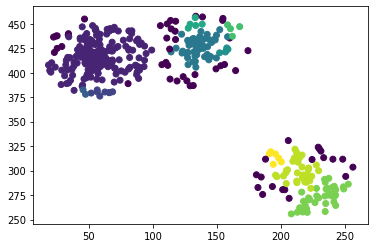

In [6]:
model_В = DBScan(points, eps=9, min_samples=6) # 7 < 9
model_В.fit()
plt.scatter(points[:,0],points[:,1],c=model_В.labels)

Модель с параметром $\varepsilon$, большим чем рекомендуемое

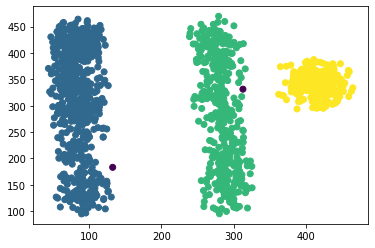

In [7]:
model_С = DBScan(points, eps=, min_samples=6) # 7 < 9
model_С.fit()
plt.scatter(points[:,0],points[:,1],c=model_С.labels)